# 04 - Public Good Score

Combine all criteria into a final Public Good Index score per state.

## Methodology (inspired by CPI)

1. **Normalize** each sub-metric using z-scores:
   - `z = (value - mean) / std_dev`
   - Rescale to 0–100 (mean ~45, std_dev ~20, clamped to [0, 100])

2. **Sub-metrics** (all oriented so higher = better public good):
   - Tax efficiency: inverse of tax burden (lower taxes = higher score)
   - Investment ratio: % of spending classified as investment
   - Service effectiveness: composite of outcome metrics

3. **Aggregate**: simple average of normalized sub-scores

Score of 100 = low taxes, high investment ratio, great outcomes
Score of 0 = high taxes, mostly cost spending, poor outcomes

**Output:** `public_good_scores.json` for D3 charts

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path

PROCESSED_DIR = Path("../data/processed")
CHARTS_DIR = Path("../docs/charts/data")
CHARTS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
def normalize_zscore(series, invert=False):
    """Normalize a series to 0-100 using z-score method (CPI-style).
    
    Args:
        series: pandas Series of raw values
        invert: if True, higher raw values produce lower scores
                (use for metrics where lower is better, like tax burden)
    """
    if invert:
        series = -series
    z = (series - series.mean()) / series.std()
    # Rescale: mean=45, std=20 (matching CPI parameters)
    scaled = z * 20 + 45
    return scaled.clip(0, 100)

In [3]:
# Load outputs from notebooks 01-03
tax_burden = pd.read_csv(PROCESSED_DIR / "tax_burden.csv")
spending = pd.read_csv(PROCESSED_DIR / "spending_breakdown.csv")
effectiveness = pd.read_csv(PROCESSED_DIR / "service_effectiveness.csv")

print(f"Tax burden:    {len(tax_burden)} states")
print(f"Spending:      {len(spending)} states")
print(f"Effectiveness: {len(effectiveness)} states")

Tax burden:    48 states
Spending:      48 states
Effectiveness: 51 states


In [4]:
# Merge all sub-metrics on state
combined = tax_burden[["state", "state_name", "total_burden"]].merge(
    spending[["state", "investment_ratio"]], on="state", how="inner"
).merge(
    effectiveness[["state", "composite_score"]], on="state", how="inner"
)

# Normalize each sub-metric using z-scores (CPI-style, 0-100)
combined["tax_score"] = normalize_zscore(combined["total_burden"], invert=True)
combined["investment_score"] = normalize_zscore(combined["investment_ratio"])
combined["effectiveness_score"] = normalize_zscore(combined["composite_score"])

# Calculate Public Good Index = simple average of three scores
combined["public_good_index"] = (
    combined["tax_score"]
    + combined["investment_score"]
    + combined["effectiveness_score"]
) / 3

# Rank states (1 = best)
combined["rank"] = combined["public_good_index"].rank(ascending=False).astype(int)

print(f"States: {len(combined)}")
print(f"Public Good Index range: {combined['public_good_index'].min():.1f}/100 – "
      f"{combined['public_good_index'].max():.1f}/100")
print(f"Mean: {combined['public_good_index'].mean():.1f}/100, "
      f"Median: {combined['public_good_index'].median():.1f}/100")

# Display with formatted scores
display_df = combined[["state", "state_name", "rank", "tax_score", "investment_score",
                        "effectiveness_score", "public_good_index"]].copy()
for col in ["tax_score", "investment_score", "effectiveness_score", "public_good_index"]:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.1f}/100")
display_df.sort_values("rank").head(10)

States: 48
Public Good Index range: 26.2/100 – 70.8/100
Mean: 45.0/100, Median: 45.4/100


,state,state_name,rank,tax_score,investment_score,effectiveness_score,public_good_index
41,UT,Utah,1,51.5/100,95.4/100,65.4/100,70.8/100
47,WY,Wyoming,2,58.4/100,66.1/100,55.5/100,60.0/100
26,NE,Nebraska,3,55.4/100,60.2/100,58.9/100,58.1/100
27,NH,New Hampshire,4,83.4/100,9.5/100,79.5/100,57.4/100
42,VA,Virginia,5,53.9/100,56.7/100,60.6/100,57.1/100
16,MA,Massachusetts,6,39.6/100,49.8/100,79.5/100,56.3/100
4,CO,Colorado,7,70.6/100,39.9/100,56.4/100,55.6/100
10,ID,Idaho,8,39.1/100,66.2/100,61.4/100,55.6/100
44,WA,Washington,9,47.0/100,56.9/100,60.9/100,54.9/100
40,TX,Texas,10,72.2/100,46.4/100,42.6/100,53.8/100


In [5]:
# Export results
# Summary scores
score_cols = ["state", "state_name", "rank", "tax_score", "investment_score",
              "effectiveness_score", "public_good_index"]
scores = combined[score_cols].sort_values("rank").reset_index(drop=True)

csv_path = PROCESSED_DIR / "public_good_scores.csv"
scores.to_csv(csv_path, index=False)
print(f"Wrote {csv_path}")

json_path = CHARTS_DIR / "public_good_scores.json"
scores.to_json(json_path, orient="records", indent=2)
print(f"Wrote {json_path}")

# Detailed output with raw values
detail_cols = ["state", "state_name", "rank", "total_burden", "investment_ratio",
               "composite_score", "tax_score", "investment_score",
               "effectiveness_score", "public_good_index"]
detailed = combined[detail_cols].sort_values("rank").reset_index(drop=True)
detail_path = PROCESSED_DIR / "public_good_detailed.csv"
detailed.to_csv(detail_path, index=False)
print(f"Wrote {detail_path}")

Wrote ../data/processed/public_good_scores.csv
Wrote ../docs/charts/data/public_good_scores.json
Wrote ../data/processed/public_good_detailed.csv


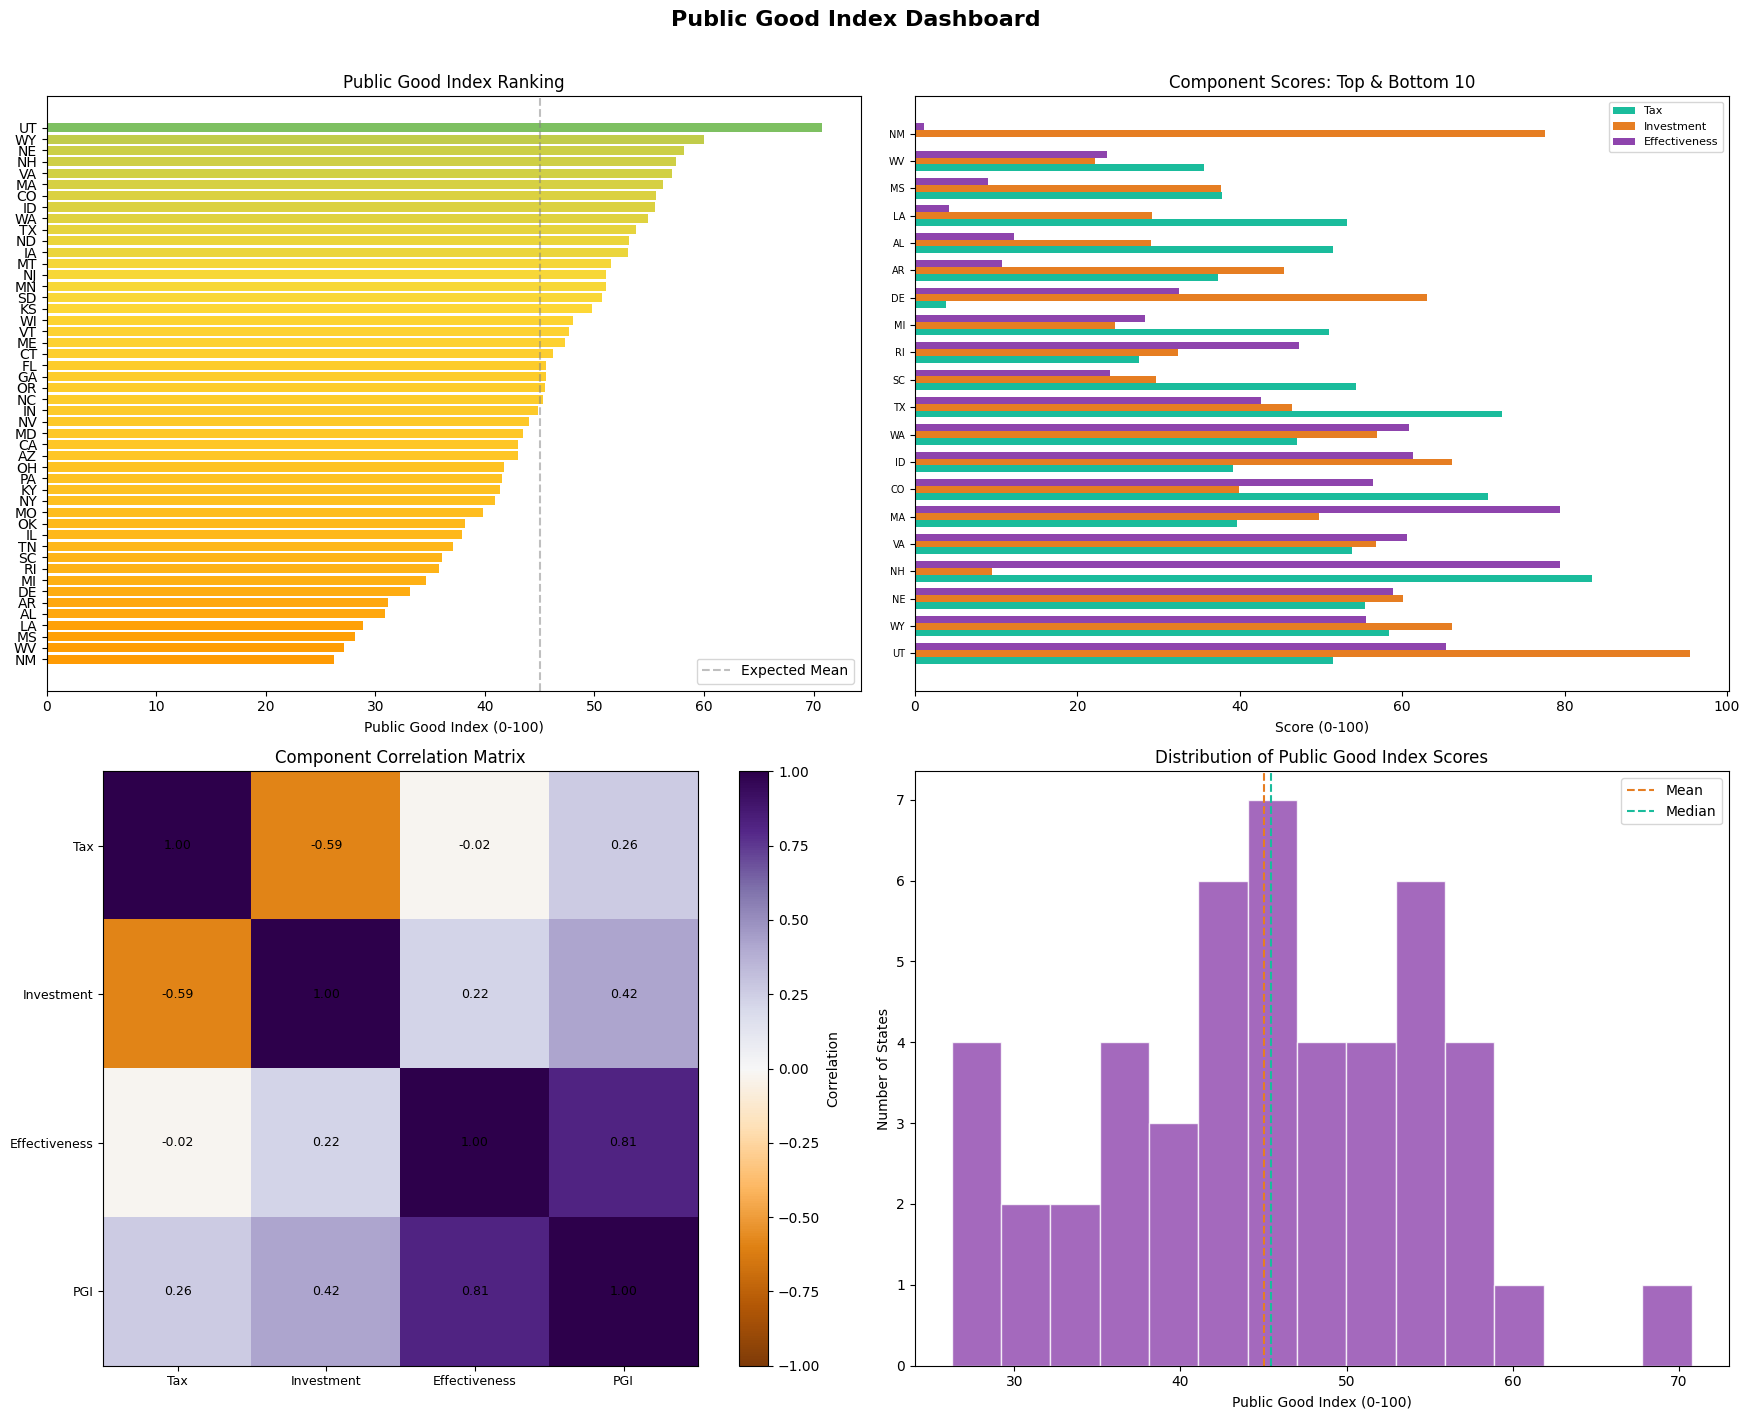

In [6]:
# Dashboard visualization
from matplotlib.colors import LinearSegmentedColormap
SCORE_CMAP = LinearSegmentedColormap.from_list("score", ["#d32f2f", "#ff9800", "#fdd835", "#66bb6a", "#2e7d32"])

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Ranking bar chart
ax1 = axes[0, 0]
plot_data = scores.sort_values("public_good_index", ascending=True)
colors = SCORE_CMAP(plot_data["public_good_index"] / 100)
ax1.barh(plot_data["state"], plot_data["public_good_index"], color=colors)
ax1.set_xlabel("Public Good Index (0-100)")
ax1.set_title("Public Good Index Ranking")
ax1.axvline(x=45, color="gray", linestyle="--", alpha=0.5, label="Expected Mean")
ax1.legend()

# 2. Component comparison (stacked bar for top/bottom 10)
ax2 = axes[0, 1]
top_bottom = pd.concat([scores.head(10), scores.tail(10)])
x = range(len(top_bottom))
w = 0.25
ax2.barh([i - w for i in x], top_bottom["tax_score"], height=w, label="Tax", color="#1abc9c")
ax2.barh(x, top_bottom["investment_score"], height=w, label="Investment", color="#e67e22")
ax2.barh([i + w for i in x], top_bottom["effectiveness_score"], height=w, label="Effectiveness", color="#8e44ad")
ax2.set_yticks(x)
ax2.set_yticklabels(top_bottom["state"], fontsize=7)
ax2.set_xlabel("Score (0-100)")
ax2.set_title("Component Scores: Top & Bottom 10")
ax2.legend(fontsize=8)

# 3. Correlation matrix
ax3 = axes[1, 0]
corr_cols = ["tax_score", "investment_score", "effectiveness_score", "public_good_index"]
corr = combined[corr_cols].corr()
im = ax3.imshow(corr, cmap="PuOr", vmin=-1, vmax=1)
ax3.set_xticks(range(len(corr_cols)))
ax3.set_yticks(range(len(corr_cols)))
labels = ["Tax", "Investment", "Effectiveness", "PGI"]
ax3.set_xticklabels(labels, fontsize=9)
ax3.set_yticklabels(labels, fontsize=9)
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        ax3.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=9)
plt.colorbar(im, ax=ax3, label="Correlation")
ax3.set_title("Component Correlation Matrix")

# 4. Histogram of PGI scores
ax4 = axes[1, 1]
ax4.hist(scores["public_good_index"], bins=15, color="#8e44ad", edgecolor="white", alpha=0.8)
ax4.axvline(x=scores["public_good_index"].mean(), color="#e67e22", linestyle="--", label="Mean")
ax4.axvline(x=scores["public_good_index"].median(), color="#1abc9c", linestyle="--", label="Median")
ax4.set_xlabel("Public Good Index (0-100)")
ax4.set_ylabel("Number of States")
ax4.set_title("Distribution of Public Good Index Scores")
ax4.legend()

plt.suptitle("Public Good Index Dashboard", fontsize=16, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

In [7]:
import plotly.express as px

SCORE_SCALE = [[0, "#d32f2f"], [0.25, "#ff9800"], [0.5, "#fdd835"], [0.75, "#66bb6a"], [1, "#2e7d32"]]

fig = px.choropleth(
    scores,
    locations="state",
    locationmode="USA-states",
    color="public_good_index",
    color_continuous_scale=SCORE_SCALE,
    range_color=[0, 100],
    scope="usa",
    hover_name="state_name",
    hover_data={
        "state": False,
        "rank": True,
        "public_good_index": ":.1f",
        "tax_score": ":.1f",
        "investment_score": ":.1f",
        "effectiveness_score": ":.1f",
    },
    labels={
        "public_good_index": "PGI (0-100)",
        "tax_score": "Tax Score (0-100)",
        "investment_score": "Investment Score (0-100)",
        "effectiveness_score": "Effectiveness Score (0-100)",
    },
    title="Public Good Index — Overall Score",
)
fig.update_layout(
    coloraxis_colorbar=dict(title="PGI"),
    geo=dict(lakecolor="rgb(255,255,255)"),
)
fig.show()

In [8]:
# Subcategory maps — Tax, Investment, Effectiveness scores
from plotly.subplots import make_subplots
import plotly.graph_objects as go

SCORE_SCALE = [[0, "#d32f2f"], [0.25, "#ff9800"], [0.5, "#fdd835"], [0.75, "#66bb6a"], [1, "#2e7d32"]]

fig = make_subplots(
    rows=1, cols=3,
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}, {"type": "choropleth"}]],
    subplot_titles=["Tax Score (0-100)", "Investment Score (0-100)", "Effectiveness Score (0-100)"],
)

for i, (col, title) in enumerate([
    ("tax_score", "Tax"),
    ("investment_score", "Investment"),
    ("effectiveness_score", "Effectiveness"),
], start=1):
    fig.add_trace(go.Choropleth(
        locations=scores["state"],
        z=scores[col],
        locationmode="USA-states",
        colorscale=SCORE_SCALE,
        zmin=0, zmax=100,
        colorbar=dict(title=title, x=-0.05 + i * 0.38, len=0.8),
        hovertext=scores["state_name"],
        hovertemplate="%{hovertext}<br>" + title + " Score: %{z:.1f}/100<extra></extra>",
    ), row=1, col=i)

fig.update_geos(scope="usa", lakecolor="rgb(255,255,255)")
fig.update_layout(title_text="Public Good Index — Component Scores", height=400)
fig.show()